In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd

# then import my own modules
from Featurization import save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [5]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LigandBased(nn.Module):

    def __init__(self, radius, input_feature_dim, input_bond_dim,\
            fingerprint_dim, output_units_num, p_dropout=0.0):
        super(LigandBased, self).__init__()
        self.dropout = nn.Dropout(p=p_dropout)
        self.atom_fc = nn.Linear(input_feature_dim, fingerprint_dim)        
        self.neighbor_fc = nn.Linear(input_feature_dim+input_bond_dim, fingerprint_dim)
        self.atom_GRU = nn.ModuleList([nn.GRUCell(fingerprint_dim, fingerprint_dim) for r in range(radius)])
        self.hidden = nn.Linear(fingerprint_dim, fingerprint_dim*2)
        self.output = nn.Linear(fingerprint_dim*2, output_units_num) 
        self.radius = radius

    def forward(self, atom_list, bond_list, atom_degree_list, bond_degree_list, atom_mask):
        atom_mask = atom_mask.unsqueeze(2)
        batch_size,mol_length,num_atom_feat = atom_list.size()
        atom_feature = F.relu(self.atom_fc(atom_list)) * atom_mask

        bond_neighbor = [bond_list[i][bond_degree_list[i]] for i in range(batch_size)]
        bond_neighbor = torch.stack(bond_neighbor, dim=0)
        atom_neighbor = [atom_list[i][atom_degree_list[i]] for i in range(batch_size)]
        atom_neighbor = torch.stack(atom_neighbor, dim=0)
        # then catenate them
        neighbor_feature = torch.cat([atom_neighbor, bond_neighbor],dim=-1)
#         print(neighbor_feature.shape, neighbor_feature[0][0])
        max_features = torch.max(neighbor_feature,dim=-2)[0]
        max_features = F.relu(self.neighbor_fc(max_features))
#         print(max_features.shape, max_features[0])
        batch_size, mol_length, fingerprint_dim = atom_feature.shape
        atom_feature_reshape = atom_feature.view(batch_size*mol_length, fingerprint_dim)
        max_features_reshape = max_features.view(batch_size*mol_length, fingerprint_dim)
        atom_feature_GRU = self.atom_GRU[0](max_features_reshape, atom_feature_reshape)
        atom_feature = atom_feature_GRU.view(batch_size, mol_length, fingerprint_dim) * atom_mask        

        for d in range(self.radius-1):
            neighbor_feature = [atom_feature[i][atom_degree_list[i]] for i in range(batch_size)]
            # neighbor_feature is a list of 3D tensor, so we need to stack them into a 4D tensor first
            neighbor_feature = torch.stack(neighbor_feature, dim=0)
            # then max-pooling 
            max_features = torch.max(neighbor_feature,dim=-2)[0]

            atom_feature_reshape = atom_feature.view(batch_size*mol_length, fingerprint_dim)
            max_features_reshape = max_features.view(batch_size*mol_length, fingerprint_dim)
            atom_feature_GRU = self.atom_GRU[d+1](max_features_reshape, atom_feature_reshape)
            atom_feature = atom_feature_GRU.view(batch_size, mol_length, fingerprint_dim) * atom_mask
        mol_feature = torch.sum(atom_feature,-2)
        hidden_feature = self.hidden(self.dropout(F.relu(mol_feature)))
        mol_prediction = self.output(self.dropout(F.relu(hidden_feature)))
        return mol_prediction

In [6]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd

kinase count: 392
similes count: 2140
number of all smiles:  2140
number of successfully processed smiles:  2140


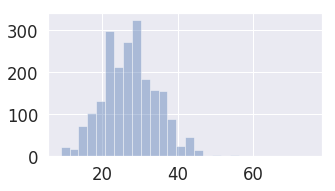

In [7]:
task_name = 'Multi-Targeting'
tasks = ['activity']
sub_task1 = ['RET','MKNK1','BRAF','SRC','RPS6KB1','TTK','MAPK15','PDPK1','PAK3']
sub_task2 = ['AURKA','PAK1','FGFR1','STK11','PAK3','MAP3K7','PIK3CA']
kinase_seq_embedding = pd.read_csv('../input/kinase_seq_embedding.csv')
smiles_kinase_activity = pd.read_csv('../input/smiles_kinase_activity.csv')
print('kinase count:',len(smiles_kinase_activity['kinase'].value_counts()))
print('similes count:',len(smiles_kinase_activity['smiles'].value_counts()))

smilesList = list(set(smiles_kinase_activity.smiles.values))
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()

In [8]:
multi_tasks = list(smiles_kinase_activity['kinase'].unique())
multi_tasks

['EPHA5',
 'EPHA8',
 'EPHB1',
 'EPHB2',
 'EPHB3',
 'EPHB4',
 'EPHB6',
 'ABL1',
 'TNK2',
 'BRSK2',
 'WNK2',
 'AKT1',
 'AKT2',
 'AKT3',
 'ALK',
 'ACVRL1',
 'ACVR1',
 'BMPR1A',
 'ACVR1B',
 'TGFBR1',
 'BMPR1B',
 'DAPK1',
 'AURKC',
 'AXL',
 'GRK2',
 'MAP4K2',
 'BLK',
 'BRAF',
 'PTK6',
 'BTK',
 'CDK7',
 'CAMK1',
 'EGFR',
 'CAMK2A',
 'CAMK2B',
 'CAMK2G',
 'CAMK4',
 'CDK1',
 'CDC7',
 'EPHA4',
 'CDK2',
 'CDK3',
 'CDK4',
 'CDK5',
 'CDK6',
 'PRKG1',
 'PRKG2',
 'CHEK1',
 'CHEK2',
 'CSNK1A1',
 'CSNK1D',
 'JAK1',
 'CSNK1E',
 'CSNK1G2',
 'CSNK1G3',
 'CSNK2A1',
 'CLK1',
 'CLK2',
 'CLK3',
 'JAK2',
 'MAP3K8',
 'CSF1R',
 'CSK',
 'MARK3',
 'MAP3K12',
 'DMPK',
 'PRKDC',
 'DYRK1B',
 'DYRK2',
 'DYRK4',
 'EEF2K',
 'EIF2AK2',
 'MARK2',
 'EPHA1',
 'EPHA2',
 'EPHA3',
 'MAPK3',
 'MAPK1',
 'PTK2',
 'FER',
 'FES',
 'FGFR1',
 'FGFR2',
 'FGFR3',
 'FGFR4',
 'FGR',
 'FLT3',
 'FLT1',
 'FLT4',
 'MTOR',
 'FYN',
 'GRK4',
 'GRK5',
 'GRK6',
 'GSK3A',
 'JAK3',
 'GSK3B',
 'HCK',
 'ERBB2',
 'ERBB4',
 'HIPK1',
 'IGF1R',
 'CHUK',

In [9]:
random_seed = 28
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 500
epochs = 100
p_dropout = 0.18
fingerprint_dim = 180

radius = 3
weight_decay = 4.5 # also known as l2_regularization_lambda
learning_rate = 2.8
embedding_dim = 100
output_units_num = 1 * len(multi_tasks) # for classification model

In [10]:
test_df = smiles_kinase_activity.sample(frac=1/10, random_state=random_seed) # test set
training_data = smiles_kinase_activity.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    test_df[task+'_normalized'] = (test_df[task]- mean)/std

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,activity,5.22636,0.79216,0.572409,1.383907


In [11]:
# predict all values as mean of each ligand will get a MSE of 0.3683609544565635
smiles_variance = smiles_kinase_activity.groupby('smiles')['activity'].var(ddof=0) * smiles_kinase_activity.groupby('smiles')['smiles'].value_counts()
print(np.sqrt(smiles_variance.sum()/smiles_kinase_activity.shape[0]))

# predict all values as mean of each protein kinase will get a MSE of 0.5583972950594606
kinase_variance = smiles_kinase_activity.groupby('kinase')['activity'].var(ddof=0) * smiles_kinase_activity.groupby('kinase')['kinase'].value_counts()
print(np.sqrt(kinase_variance.sum()/smiles_kinase_activity.shape[0]))

0.6067693844481934
0.7473647274436619


In [12]:
# predict all values as mean of each ligand will get a MSE of 0.3683609544565635
smiles_variance = training_data.groupby('smiles')['activity'].var(ddof=0) * training_data.groupby('smiles')['smiles'].value_counts()
print(np.sqrt(smiles_variance.sum()/training_data.shape[0]))

# predict all values as mean of each protein kinase will get a MSE of 0.5583972950594606
kinase_variance = training_data.groupby('kinase')['activity'].var(ddof=0) * training_data.groupby('kinase')['kinase'].value_counts()
print(np.sqrt(kinase_variance.sum()/training_data.shape[0]))

0.6055113264956725
0.7465290722867107


In [13]:
feature_dicts = get_smiles_dicts(smilesList)
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = nn.MSELoss()
model = LigandBased(radius, num_atom_features, num_bond_features,\
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)


In [14]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

809312
atom_fc.weight torch.Size([180, 39])
atom_fc.bias torch.Size([180])
neighbor_fc.weight torch.Size([180, 49])
neighbor_fc.bias torch.Size([180])
atom_GRU.0.weight_ih torch.Size([540, 180])
atom_GRU.0.weight_hh torch.Size([540, 180])
atom_GRU.0.bias_ih torch.Size([540])
atom_GRU.0.bias_hh torch.Size([540])
atom_GRU.1.weight_ih torch.Size([540, 180])
atom_GRU.1.weight_hh torch.Size([540, 180])
atom_GRU.1.bias_ih torch.Size([540])
atom_GRU.1.bias_hh torch.Size([540])
atom_GRU.2.weight_ih torch.Size([540, 180])
atom_GRU.2.weight_hh torch.Size([540, 180])
atom_GRU.2.bias_ih torch.Size([540])
atom_GRU.2.bias_hh torch.Size([540])
hidden.weight torch.Size([360, 180])
hidden.bias torch.Size([360])
output.weight torch.Size([392, 360])
output.bias torch.Size([392])


In [15]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        y_val = batch_df['activity_normalized'].values
        tasks_mask = torch.cuda.ByteTensor([np.array([x == task for task in multi_tasks]) for x in batch_df['kinase']])
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),\
                                                 torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        model.zero_grad()
        mol_prediction = torch.masked_select(mol_prediction, tasks_mask)
        # Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = loss_function(mol_prediction, torch.Tensor(y_val))
        # Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        y_val = batch_df['activity_normalized'].values
        
        tasks_mask = torch.cuda.ByteTensor([np.array([x == task for task in multi_tasks]) for x in batch_df['kinase']])

        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),\
                                                 torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))

        mol_prediction = torch.masked_select(mol_prediction, tasks_mask)
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val), reduction='none')
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val), reduction='none')
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    eval_MAE_nomalized = np.array(eval_MAE_list).mean()
    eval_MSE_nomalized = np.array(eval_MSE_list).mean()
    eval_MAE = eval_MAE_nomalized * std_list[0]
    eval_MSE = eval_MSE_nomalized * std_list[0] * std_list[0]
    return eval_MAE, eval_MSE

In [16]:
for epoch in range(60):
    valid_MAE, valid_MSE = eval(model, valid_df)
    train_MAE, train_MSE = eval(model, train_df)
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    
    %time train(model, train_df, optimizer, loss_function)


0 0.9536241913759269 0.956613629862973
CPU times: user 3min 25s, sys: 2min 30s, total: 5min 56s
Wall time: 5min 56s
1 0.7133326555677681 0.7233447184163486
CPU times: user 3min 25s, sys: 2min 30s, total: 5min 56s
Wall time: 5min 56s
2 0.6377057436480472 0.6515253671044201
CPU times: user 3min 24s, sys: 2min 31s, total: 5min 55s
Wall time: 5min 55s
3 0.6081096215479306 0.6229367495611846
CPU times: user 3min 21s, sys: 2min 32s, total: 5min 53s
Wall time: 5min 54s
4 0.5752693479875884 0.5914621252121979
CPU times: user 3min 21s, sys: 2min 33s, total: 5min 54s
Wall time: 5min 55s
5 0.5641677451764812 0.5816439155629329
CPU times: user 3min 21s, sys: 2min 33s, total: 5min 54s
Wall time: 5min 55s
6 0.5566060445772274 0.5758131633842535
CPU times: user 3min 19s, sys: 2min 34s, total: 5min 54s
Wall time: 5min 54s
7 0.5600872362607564 0.5793824231181218
CPU times: user 3min 18s, sys: 2min 34s, total: 5min 53s
Wall time: 5min 53s
8 0.5421865477891409 0.5637343899938798
CPU times: user 3min 19s,